# CNN Example

In [2]:
!pip install git+https://github.com/fastai/fastai.git

  Cloning https://github.com/fastai/fastai.git to /private/var/folders/vn/kmndv9r10458n_57pj_2jwh80000gp/T/pip-53soxun5-build
  Using cached https://files.pythonhosted.org/packages/c2/d4/fe7e2637975c476734fcbf53776e650a29680194eb0dd21dbdc020ca92de/isoweek-1.3.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/20/67/150d84f30a8cc6e2af20bc06d5db156ccde03e0922196383086cceaa253b/opencv_python-3.4.3.18-cp36-cp36m-macosx_10_6_x86_64.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/97/55/ea54109a4e7a8e7342bdf23e9382c858224263d984b0d95610568e564f59/pandas_summary-0.0.5-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/fe/49/7af942bc63277dfca6ad397415f4cff60789c56d173b1f7edf0bd30e27e0/plotnine-0.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7e/9c/c94f46b40b86d2c77c46c4c1b858fc66c117b4390665eca28f2e0812db45/sklearn_pandas-1.7

  Using cached https://files.pythonhosted.org/packages/52/01/8a3b4c6e45749674a1e5241174b4b63cd6435125e124bec275f3e02c96ac/mizani-0.4.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e5/b6/1ed2eb03989ae574584664985367ba70cd9cf8b32ee8cad0e8aaeac819f3/descartes-1.1.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/24/11/d77c157c16909bd77557d00798b05a5b6615ed60acb5900fbe6a65d35e93/geopandas-0.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9e/9b/62c60d2f5bc135d2aa1d8c8a86aaf84edb719a59c7f11a4316259e61a298/plac-0.9.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/56/8a/84537c0354f0d1f03bf644b71bf8e0a50db9c1294181905721a5f3efbf66/palettable-3.1.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c9/1c/4db85f68ebbe6532885b1d8a83efb631cfee8a52e70359f435a85984d18e/Fiona-1.7.13-cp36-cp36m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/p

In [485]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.conv_learner import ConvLearner
from fastai.transforms import RandomRotate, RandomLighting, tfms_from_model, CropType, TfmType
from fastai.dataset import ImageClassifierData
from torchvision.models.resnet import resnet101
from matplotlib import patches, patheffects
from torch import nn
from torch import optim

In [486]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [487]:
from pathlib import Path

In [488]:
PATH = Path('../data')

In [489]:
imgs = []
classes = []
bbs = []

from tqdm import tqdm
import math


for p in tqdm((PATH/'yolo').iterdir()):
    fn = p.parts[-1]

    if fn.endswith('.jpg'):
        imgs.append(fn)
        height, width, channels = plt.imread(p).shape

        labels = open(str(p).replace('.jpg', '.txt')).read().split()
        cls = int(labels[0])
        xmin, ymin, bb_width, bb_height = labels[1:]
        
        bb_width_scaled = float(bb_width) * float(width)
        bb_height_scaled = float(bb_height) * float(height)
        
        # Have to unscale from Yolo format
        x = int(round(float(xmin) * float(width)))
        
        y = int(round(float(ymin) * float(height)))
                
        x2 = int(round(x + bb_width_scaled))
        y2 = int(round(y + bb_height_scaled))
            
        # Dunno why Fast.ai format has to be like this
        bb = f'{y} {x} {y2} {x2}'
        
        bbs.append(bb)
        classes.append(cls)

1872it [00:09, 207.68it/s]


In [490]:
len(bbs)

936

In [491]:
classes_df = pd.DataFrame({'image': imgs, 'class': classes})[['image', 'class']]
bbs_df = pd.DataFrame({'image': imgs, 'bb': bbs})[['image', 'bb']]

In [492]:
classes_df.to_csv(PATH/'train_classes.csv', index=False, columns=['image', 'class'])
bbs_df.to_csv(PATH/'train_bbs.csv', index=False, columns=['image', 'bb'])

In [493]:
classes_df.head()

,image,class
0,EBH3wdRtZyg-frame-5854.jpg,18
1,EBH3wdRtZyg-frame-5897.jpg,19
2,EBH3wdRtZyg-frame-4237.jpg,1
3,pAz_mIjHglw-frame-528.jpg,11
4,33qU9tQlEa4-frame-610.jpg,3


In [494]:
bbs_df.head()

,image,bb
0,EBH3wdRtZyg-frame-5854.jpg,151 34 360 295
1,EBH3wdRtZyg-frame-5897.jpg,81 75 360 241
2,EBH3wdRtZyg-frame-4237.jpg,115 108 311 393
3,pAz_mIjHglw-frame-528.jpg,150 173 507 538
4,33qU9tQlEa4-frame-610.jpg,173 324 644 868


## Bounding box detection

In [495]:
augs = [RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [496]:
f_model = resnet101
sz = 224

In [497]:
import fastai

In [498]:
fastai.__file__

'/Users/lex/anaconda3/lib/python3.6/site-packages/fastai/__init__.py'

In [537]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs, tfm_y=TfmType.COORD, norm_y=False)
md = ImageClassifierData.from_csv(PATH, 'yolo', PATH/'train_bbs.csv', tfms=tfms, continuous=True, bs=16)

<class 'fastai.dataset.FilesIndexArrayRegressionDataset'>
[ 23.  68. 222. 174.]


In [500]:
PATH

PosixPath('../data')

In [501]:
from fastai.core import to_np

In [502]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [503]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [504]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [505]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

[ 52.  40.  64. 131.]
[ 46.  45.  76. 141.]
[ 42.  16.  90. 152.]
[ 46.  28.  77. 142.]
[ 52.  43.  63. 128.]
[ 48.  44.  70. 136.]
[ 53.  44.  61. 127.]
[ 46.  45.  75. 140.]
[ 41.  47.  87. 151.]


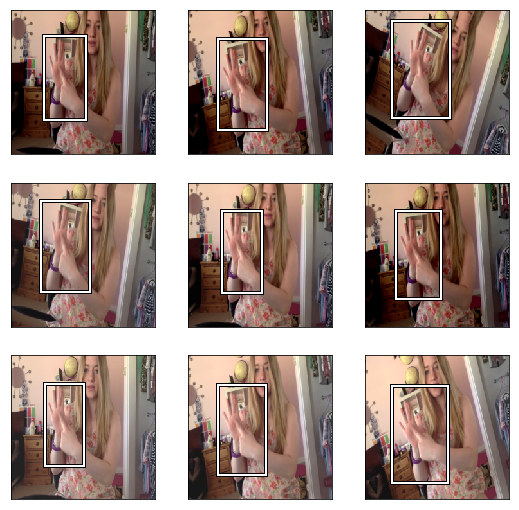

In [506]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]

    b = bb_hw(to_np(y[idx]))
    show_img(ima, ax=ax)
    print(b)
    draw_rect(ax, b)#[128.,  75., 222., 154.])

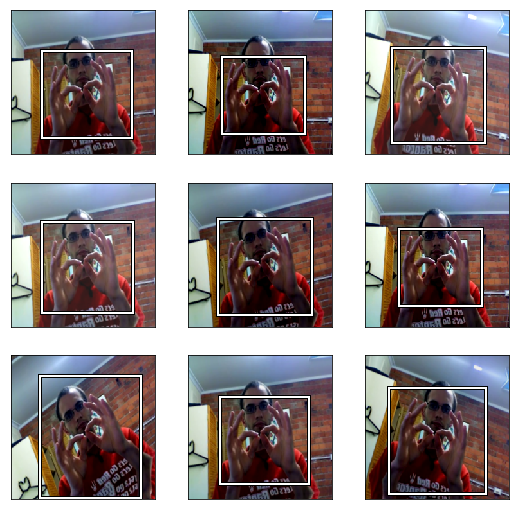

In [507]:
idx=0
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]

    b = bb_hw(to_np(y[idx]))
    #b =to_np(y[idx])
    show_img(ima, ax=ax)
    draw_rect(ax, b)

[129.  50.  90. 167.]
[130.  53.  88. 165.]
[129.  74.  84. 149.]
[131.  63.  84. 157.]
[132.  68.  82. 153.]
[100.  94. 110. 129.]
[120.  79.  94. 144.]
[132.  72.  80. 150.]
[132.  72.  80. 150.]


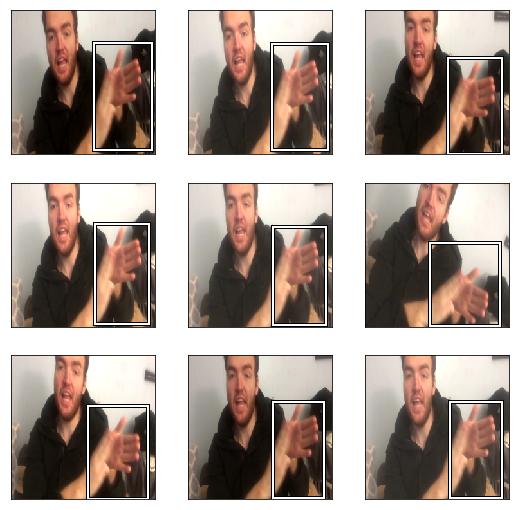

In [508]:
idx=2
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]

    b = bb_hw(to_np(y[idx]))
    show_img(ima, ax=ax)
    print(b)
    draw_rect(ax, b)

In [527]:
2048*7*7

100352

In [528]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(100352,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 61%|██████    | 114/188 [01:56<01:15,  1.02s/it, loss=185] 

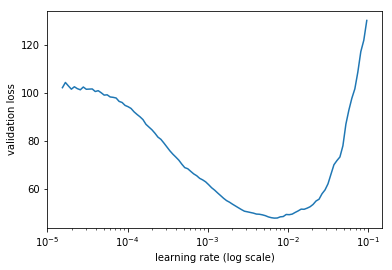

In [529]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [547]:
lr = 0.002

In [548]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 20%|██        | 38/188 [00:39<02:36,  1.04s/it, loss=99.6]

KeyboardInterrupt: 

In [ ]:
lrs = np.array([lr/100, lr/10, lr])

In [ ]:
learn.freeze_to(-2)

In [ ]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit(lrs, 1, cycle_len=2)

## Evaluate

In [539]:
from fastai.core import VV

In [549]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

In [550]:
preds

array([[ 81.0064 ,  73.47249, 293.5531 , 241.19135],
       [ 18.47985,  21.22301, 160.49478, 158.33847],
       [ 24.07174,  68.76344, 215.2336 , 161.97253],
       [ 24.76595,  22.12919, 163.37988, 162.57722],
       [ 27.05225,  15.09359, 185.00082, 170.04399],
       [ 87.95679,  87.66375, 216.89772, 218.62117],
       [ 37.37733,  70.83725, 232.42476, 170.56317],
       [ 41.8038 ,  25.13569, 171.46036, 164.42825],
       [ 22.27525,  24.0998 , 169.3927 , 175.56628],
       [ 81.09868,  73.55853, 293.78668, 241.40108],
       [-10.45635,  -6.90733, 119.22049, 135.79367],
       [ 82.71284,  18.66163, 328.2067 , 259.74203],
       [-12.71053,  28.87455, 201.38826, 142.28476],
       [ 19.64002,  23.52983, 170.30301, 173.4833 ],
       [ 20.63378,  25.52859, 169.9196 , 175.93657],
       [ 52.4631 ,  68.88692, 224.8305 , 170.05264]], dtype=float32)

In [551]:
x.shape

torch.Size([16, 3, 224, 224])

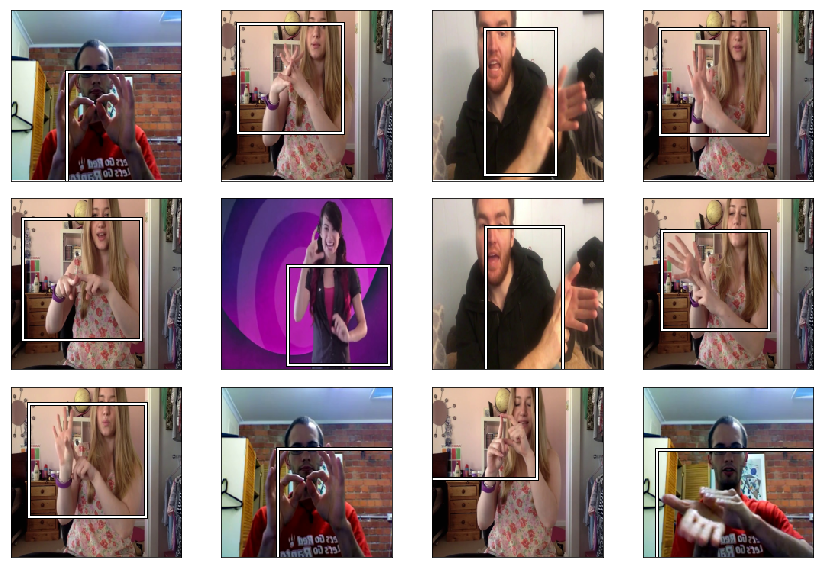

In [552]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima= md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)

plt.tight_layout()